In [1]:
!pip install scikit-lego

In [2]:
import xarray as xr
import rioxarray
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklego.meta import ZeroInflatedRegressor
from sklearn.model_selection import train_test_split
import os

try:
    import util
except ImportError:
    if 'notebooks' in os.getcwd():
        os.chdir("..")
finally:
    import util

/home/jovyan/ForestLST/util/__init__.py:13: UserWarning: PyTorch not found! Module util.training will not be loaded.
  warnings.warn("PyTorch not found! Module util.training will not be loaded.")


In [3]:
# Prepare data - since we are working with tabular data here we convert
# to a dataframe.
ds = xr.open_dataset("data_working/westmort.nc")

# Calculate total basal area based on all the genus rasters
ba_vars = ["abies", "picea", "populus", "tsuga", "pseudotsuga"]
ds["forest_ba"] = ds[ba_vars].to_stacked_array("band", sample_dims=["x", "y", "time"]).sum(dim="band")

# Smoothing
ds["mort_ewma"] = xr.apply_ufunc(
    util.manip.numpy_ewma_vectorized,
    ds.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)

# Average over time
ds["mortality_average"] = np.nancumsum(ds.mortality, axis=2) / np.cumsum(~np.isnan(ds.mortality), axis=2)

# Shift so we are doing proper out-year forecasting
ds["mort_nextyear"] = ds["mortality"].shift(time=-1)

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


In [4]:
df = ds[["elev", "forest_ba", "fire", "mort_ewma", "mort_nextyear", "mortality_average", "prcp", "vp", "vod"]].to_dataframe().reset_index().dropna()
df

,time,y,x,elev,forest_ba,fire,mort_ewma,mort_nextyear,mortality_average,prcp,vp,vod
620457,1998,4682302.419,-1.242622e+07,3118.0,49.0,0.0,2.000000,1.0,2.0,868.0,733.0,452.0
620458,1998,4682302.419,-1.242222e+07,3081.0,39.0,0.0,1.500000,1.0,2.0,931.0,695.0,452.0
622216,1998,4670302.419,-1.247022e+07,2809.0,65.0,0.0,3.000000,1.0,4.0,779.0,876.0,444.0
622217,1998,4670302.419,-1.246622e+07,2979.0,98.0,0.0,1.500000,0.0,3.0,822.0,868.0,456.0
622806,1998,4666302.419,-1.247022e+07,2851.0,61.0,0.0,0.750000,0.0,1.0,778.0,833.0,444.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8461005,2018,3686302.419,-1.227422e+07,1714.0,0.0,0.0,0.000000,0.0,0.0,471.0,1348.0,358.0
8461593,2018,3682302.419,-1.228222e+07,1897.0,4.0,0.0,0.000008,0.0,0.0,571.0,1357.0,358.0
8461594,2018,3682302.419,-1.227822e+07,2000.0,21.0,0.0,0.000128,0.0,0.0,731.0,1317.0,358.0
8461595,2018,3682302.419,-1.227422e+07,1856.0,0.0,0.0,0.000092,0.0,0.0,496.0,1365.0,358.0


In [5]:
years = ds.time.values

train_years = years[16:]
valid_years = years[:8]
test_years = years[8:16]

#df_train = df[df.time.isin(train_years)]
#df_valid = df[df.time.isin(valid_years)]
df_test  = df[df.time.isin(test_years)]
df_train_valid = df[~df.time.isin(test_years)]
df_train, df_valid = train_test_split(df_train_valid, train_size=0.7, test_size=0.3)

exclude = ["time", "y", "x", "mortality_average"]

df_train = df_train.drop(columns=exclude)
df_valid = df_valid.drop(columns=exclude)
df_test  = df_test.drop(columns=exclude)

In [6]:
def split_xy(df, target):
    return (
        df.drop(columns=target).to_numpy(),
        df[target].to_numpy()
    )

def get_results(m, X, y):
    y_hat = m.predict(X)
    return {
        "mse": mean_squared_error(y, y_hat),
        "nrmse": np.sqrt(mean_squared_error(y, y_hat)) / np.mean(y),
        "r2": explained_variance_score(y, y_hat)
    }

In [7]:
# Training
target = "mort_nextyear"

m = RandomForestRegressor(
    oob_score=True,
    max_features="sqrt"
)

zir = ZeroInflatedRegressor(
    classifier=RandomForestClassifier(oob_score=True, max_features="sqrt"),
    regressor=RandomForestRegressor(oob_score=True, max_features="sqrt")
)

downsample_factor = 5

X, y = split_xy(df_train, target)

X_downsamp = X[::downsample_factor]
y_downsamp = y[::downsample_factor]

m.fit(
    X_downsamp, y_downsamp
)

zir.fit(
    X_downsamp, y_downsamp
)

# This is artificially inflated because we aren't running
# on out of bag samples. Need to use the oob_prediction_
# property.
# train_result = get_results(m, X, y)
# print(train_result)

ZeroInflatedRegressor(classifier=RandomForestClassifier(oob_score=True),
                      regressor=RandomForestRegressor(max_features='sqrt',
                                                      oob_score=True))

In [8]:
# This is a more accurate representation of training R2
print({
    "mse": mean_squared_error(y_downsamp, m.oob_prediction_),
    "r2": explained_variance_score(y_downsamp, m.oob_prediction_)
})

{'mse': 1.303622957673468, 'r2': 0.2715385601408645}


In [9]:
print({
    "mse": mean_squared_error(y, zir.predict(X)),
    "r2": explained_variance_score(y, zir.predict(X))
})

{'mse': 1.2380452977276497, 'r2': 0.34456219118059384}


In [10]:
X_valid, y_valid = split_xy(df_valid, target)
valid_result_zir = get_results(zir, X_valid, y_valid)
valid_result_m   = get_results(m, X_valid, y_valid)
print(valid_result_zir)
print(valid_result_m)

{'mse': 1.4329753664554206, 'nrmse': 3.5803952936554984, 'r2': 0.20182871094995747}
{'mse': 1.264638302798261, 'nrmse': 3.363525936482097, 'r2': 0.28802502466789437}


In [11]:
X_test, y_test = split_xy(df_test, target)
test_result_m = get_results(m, X_test, y_test)
test_result_zir = get_results(zir, X_test, y_test)
print(test_result_m)
print(test_result_zir)

{'mse': 0.66333525040571, 'nrmse': 3.9111963533824583, 'r2': 0.12715157684750755}
{'mse': 0.8638915469267157, 'nrmse': 4.463470750810832, 'r2': -0.17597917396387075}


In [12]:
def get_lastobs_error(ds, target):
    y = ds[target].values.flatten()
    y_hat = ds[target].shift(time=-1).values.flatten()

    # remove nans from calculation
    mask = (~np.isnan(y)) & (~np.isnan(y_hat))
    y = y[mask]
    y_hat = y_hat[mask]

    return {
        "mse": mean_squared_error(y, y_hat),
        "r2": explained_variance_score(y, y_hat)
    }

def get_time_average_error(ds, target):
    time_avg = (np.nancumsum(ds[target], axis=2) / np.cumsum(~np.isnan(ds[target]), axis=2)).values.flatten()
    y = ds[target].values.flatten()

    mask = ~np.isnan(time_avg) & ~np.isnan(y)
    y = y[mask]
    time_avg = time_avg[mask]

    return {
        "mse": mean_squared_error(y, time_avg),
        "r2": explained_variance_score(y, time_avg)
    } 

In [13]:
print(get_lastobs_error(ds.sel(time=train_years), "mortality"))
print(get_time_average_error(ds.sel(time=train_years), "mortality"))

{'mse': 3.377322, 'r2': -0.24902129173278809}
{'mse': 2.5810827169231323, 'r2': 0.12648711151238134}


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


In [14]:
print(get_lastobs_error(ds.sel(time=valid_years), "mortality"))
print(get_time_average_error(ds.sel(time=valid_years), "mortality"))

{'mse': 0.9928823, 'r2': -0.4988454580307007}
{'mse': 0.6889223392449768, 'r2': 0.16921906852009283}


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


In [15]:
print(get_lastobs_error(ds.sel(time=test_years), "mortality"))
print(get_time_average_error(ds.sel(time=test_years), "mortality"))

{'mse': 0.61604965, 'r2': 0.17630469799041748}
{'mse': 0.6793979158411755, 'r2': 0.09767320805724733}


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


In [16]:
X, y = split_xy(df_valid, "mort_nextyear")
y_hat_valid = m.predict(X)

In [17]:
from scipy.stats import gaussian_kde

def one_to_one_plot(x, y, downsample_factor=10):
    x = x[::downsample_factor]
    y = y[::downsample_factor]

    k = gaussian_kde(np.vstack([x, y]))
    xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=0.5)

# very slow
#one_to_one_plot(y, y_hat_valid)

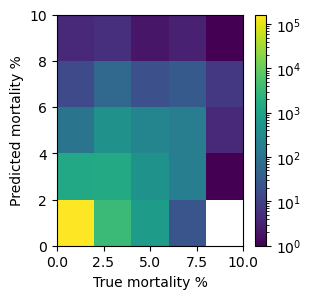

In [18]:
from matplotlib.colors import LogNorm

def one_to_one_plot2(x, y, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    Z, xedges, yedges = np.histogram2d(x, y, bins=50, range=[[0, 100], [0, 100]])
    cm = ax.pcolormesh(xedges, yedges, Z.T, norm=LogNorm())
    return cm, ax

fig, ax = plt.subplots(figsize=(3, 3))
cm, _ = one_to_one_plot2(y, y_hat_valid, ax=ax)
ax.set_xlabel("True mortality %")
ax.set_ylabel("Predicted mortality %")
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
fig.colorbar(cm, ax=ax)
plt.show()

In [19]:
ds["mort_nextyear"] = ds["mortality"].shift(time=-1)
ds["mort_ewma_nextyear"] = ds["mort_ewma"].shift(time=-1)
df = ds[["elev", "forest_ba", "fire", "mort_ewma", "mort_nextyear", "mort_ewma_nextyear", "mortality_average", "prcp", "vp", "vod"]].to_dataframe().dropna().reset_index()
df

,time,y,x,elev,forest_ba,fire,mort_ewma,mort_nextyear,mort_ewma_nextyear,mortality_average,prcp,vp,vod
0,1998,4682302.419,-1.242622e+07,3118.0,49.0,0.0,2.000000,1.0,1.500000,2.0,868.0,733.0,452.0
1,1998,4682302.419,-1.242222e+07,3081.0,39.0,0.0,1.500000,1.0,1.250000,2.0,931.0,695.0,452.0
2,1998,4670302.419,-1.247022e+07,2809.0,65.0,0.0,3.000000,1.0,2.000000,4.0,779.0,876.0,444.0
3,1998,4670302.419,-1.246622e+07,2979.0,98.0,0.0,1.500000,0.0,0.750000,3.0,822.0,868.0,456.0
4,1998,4666302.419,-1.247022e+07,2851.0,61.0,0.0,0.750000,0.0,0.375000,1.0,778.0,833.0,444.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887778,2018,3686302.419,-1.227422e+07,1714.0,0.0,0.0,0.000000,0.0,0.000000,0.0,471.0,1348.0,358.0
887779,2018,3682302.419,-1.228222e+07,1897.0,4.0,0.0,0.000008,0.0,0.000004,0.0,571.0,1357.0,358.0
887780,2018,3682302.419,-1.227822e+07,2000.0,21.0,0.0,0.000128,0.0,0.000064,0.0,731.0,1317.0,358.0
887781,2018,3682302.419,-1.227422e+07,1856.0,0.0,0.0,0.000092,0.0,0.000046,0.0,496.0,1365.0,358.0


In [20]:
# df.to_csv("data_working/westmort_tabular.csv")